In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import dataclasses
from dataclasses import dataclass, fields, _MISSING_TYPE
from heapq import heappush, heappop, heappushpop
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm
from scipy.spatial.distance import cityblock, minkowski, jaccard
from scipy.stats import pearsonr
import yake
from copy import deepcopy
import sys
sys.path.append("../")
import abstract_state
import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.stats import ks_2samp
from eval_utils import Evaluator, text_filter

In [9]:
load_path = "../hallucination_detection/response_data/"
dataset_name = "reponse_wiki_qa_train_873.json"
df = pd.read_json(load_path+dataset_name)

nlp = spacy.load("en_core_web_lg")
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
evaluator = Evaluator(nlp, model)

In [10]:
# target_tags = set(["NOUN", "PRON", "PROPN", "NN", "NNP", "NNPS", "NNS", "NE", "NNE", "VERB", "NUM", "ADJ", "ADV"])
target_tags = set(["NOUN","VERB", "NUM", "ADJ", "ADV"])

sample_feature = get_response_feature(df.loc[0])["feature"]
threshold = 0.3

feature = {}
feature_names = list(sample_feature.keys())
for key in feature_names:
    feature[key] = []

filtered_cosine = []
valina_cosine = []
alternative = []

for i in tqdm.tqdm(np.arange(len(df))):
    result = get_response_feature(df.loc[i])
    for key in feature_names:
        feature[key].append(result["feature"][key])

    alternative.append(result["alternative"])
    response = text_filter(df.loc[i, "text"], nlp, target_tags, is_lemma=False)
    true_answer = text_filter(df.loc[i, "answer"], nlp, target_tags, is_lemma=False)
    filtered_cosine.append(evaluator.compute_passage_score(response, true_answer)["cosine"])
    # valina_cosine.append(evaluator.compute_passage_score(df.loc[i, "text"], df.loc[i, "answer"])["cosine"])

binary_label = np.array(filtered_cosine) < threshold


100%|██████████| 873/873 [01:11<00:00, 12.29it/s]


entropy_mean: -0.04249542730588644
entropy_max: -0.014704429144171362
entropy_diff_mean: -0.03176980593071297
entropy_diff_max: 7.514033342147348e-06
prob_mean: 0.056221955507319746
prob_min: 0.0793557555723308
prob_diff_mean: -0.05623436715226995
prob_diff_max: -0.018599351226712996


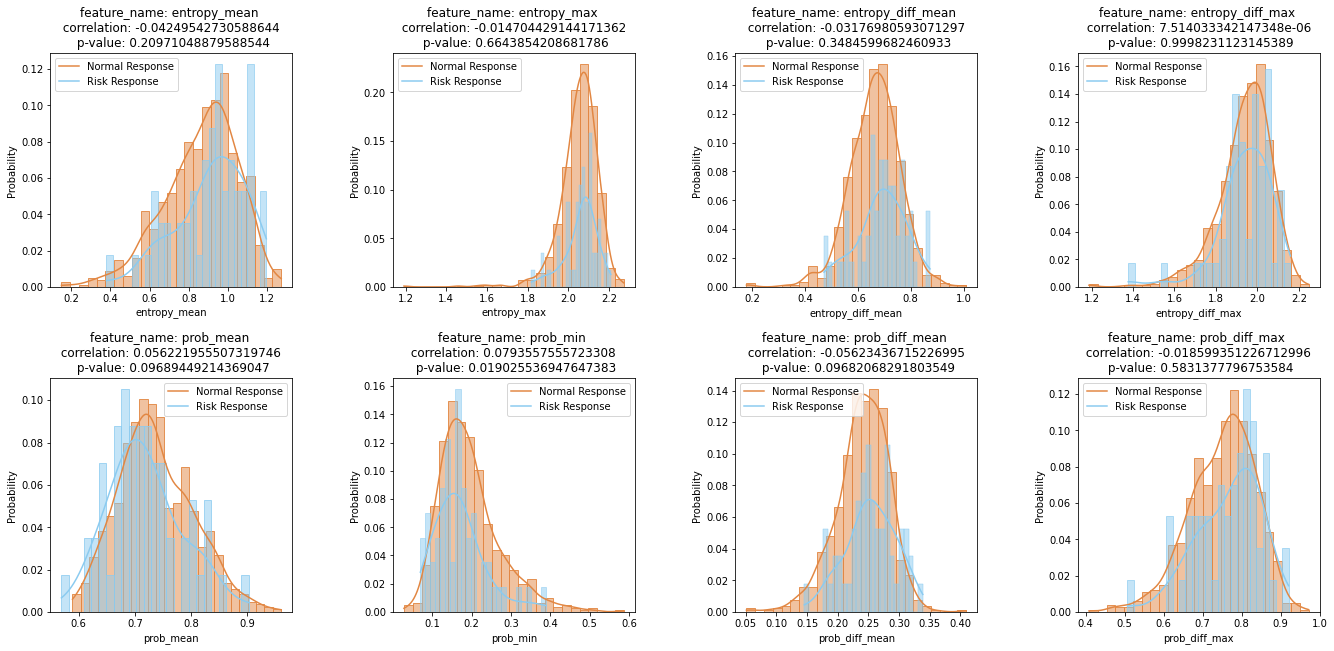

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=False)
fig.tight_layout(pad=7.0)

feature_index = 0
for i in range(0, 2):
    for j in range(0 ,4):
        name = feature_names[feature_index]
        sns.histplot(np.array(feature[name])[~binary_label], kde=True, bins=25, stat="probability", color='#e28743', edgecolor='#e28743', ax=axes[i,j])
        sns.histplot(np.array(feature[name])[binary_label], kde=True, bins=25, stat="probability", color='#8bcbf0', edgecolor='#8bcbf0', ax=axes[i,j])
        correlation, p_value = pearsonr(feature[name], filtered_cosine)
        axes[i,j].set_title(f"feature_name: {name} \n correlation: {correlation} \n p-value: {p_value}")        # Performs the two-sample Kolmogorov-Smirnov test
        axes[i,j].legend(labels=['Normal Response','Risk Response'])
        axes[i,j].set_xlabel(name)
        feature_index += 1
        print(f"{name}: {correlation}")
        
        